In [13]:
from __future__ import absolute_import, division, print_function
import matplotlib
matplotlib.use('TkAgg')
import time
# import random
import scipy.io
import tensorflow as tf
# from tensorflow import keras
# import keras
from keras import backend as K
from keras.layers import Dense, Input, merge
from keras.models import Sequential, model_from_json
from keras.engine.topology import Layer
from keras.callbacks import Callback, EarlyStopping
import numpy as np

import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import kde
import os
import csv
from sklearn.metrics import mean_squared_error
"""
A Mixture Density Layer for Keras
cpmpercussion: Charles Martin (University of Oslo) 2018
https://github.com/cpmpercussion/keras-mdn-layer
Hat tip to [Omimo's Keras MDN layer](https://github.com/omimo/Keras-MDN) for a starting point for this code.
"""
import keras
from keras import backend as K
from keras.layers import Dense
from keras.engine.topology import Layer
import numpy as np
from tensorflow.contrib.distributions import Categorical, Mixture, MultivariateNormalDiag
import tensorflow as tf

Now, we define MDN layer

In [6]:
def elu_plus_one_plus_epsilon(x):
    """ELU activation with a very small addition to help prevent NaN in loss."""
    return (K.elu(x) + 1 + 1e-8)


class MDN(Layer):
    """A Mixture Density Network Layer for Keras.
    This layer has a few tricks to avoid NaNs in the loss function when training:
        - Activation for variances is ELU + 1 + 1e-8 (to avoid very small values)
        - Mixture weights (pi) are trained in as logits, not in the softmax space.
    A loss function needs to be constructed with the same output dimension and number of mixtures.
    A sampling function is also provided to sample from distribution parametrised by the MDN outputs.
    """

    def __init__(self, output_dimension, num_mixtures, **kwargs):
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        with tf.name_scope('MDN'):
            self.mdn_mus = Dense(self.num_mix * self.output_dim, name='mdn_mus')  # mix*output vals, no activation
            self.mdn_sigmas = Dense(self.num_mix * self.output_dim, activation=elu_plus_one_plus_epsilon, name='mdn_sigmas')  # mix*output vals exp activation
            self.mdn_pi = Dense(self.num_mix, name='mdn_pi')  # mix vals, logits
        super(MDN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        self.trainable_weights = self.mdn_mus.trainable_weights + self.mdn_sigmas.trainable_weights + self.mdn_pi.trainable_weights
        self.non_trainable_weights = self.mdn_mus.non_trainable_weights + self.mdn_sigmas.non_trainable_weights + self.mdn_pi.non_trainable_weights
        super(MDN, self).build(input_shape)

    def call(self, x, mask=None):
        with tf.name_scope('MDN'):
            mdn_out = keras.layers.concatenate([self.mdn_mus(x),
                                                self.mdn_sigmas(x),
                                                self.mdn_pi(x)],
                                               name='mdn_outputs')
        return mdn_out

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {
            "output_dimension": self.output_dim,
            "num_mixtures": self.num_mix
        }
        base_config = super(MDN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def get_mixture_loss_func(output_dim, num_mixes):
    """Construct a loss functions for the MDN layer parametrised by number of mixtures."""
    # Construct a loss function with the right number of mixtures and outputs
    def loss_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss

    # Actually return the loss_func
    with tf.name_scope('MDN'):
        return loss_func


def get_mixture_sampling_fun(output_dim, num_mixes):
    """Construct a sampling function for the MDN layer parametrised by mixtures and output dimension."""
    # Construct a loss function with the right number of mixtures and outputs
    def sampling_func(y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        # Todo: temperature adjustment for sampling function.
        return samp

    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return sampling_func


def get_mixture_mse_accuracy(output_dim, num_mixes):
    """Construct an MSE accuracy function for the MDN layer
    that takes one sample and compares to the true value."""
    # Construct a loss function with the right number of mixtures and outputs
    def mse_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        mse = tf.reduce_mean(tf.square(samp - y_true), axis=-1)
        # Todo: temperature adjustment for sampling functon.
        return mse

    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return mse_func


def split_mixture_params(params, output_dim, num_mixes):
    """Splits up an array of mixture parameters into mus, sigmas, and pis
    depending on the number of mixtures and output dimension."""
    mus = params[:num_mixes*output_dim]
    sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits


def softmax(w, t=1.0):
    """Softmax function for a list or numpy array of logits. Also adjusts temperature."""
    e = np.array(w) / t  # adjust temperature
    e -= np.max(e, axis=1, keepdims=1)  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e, axis=1, keepdims=1)
    return dist


def sample_from_categorical(dist):
    """Samples from a categorical model PDF."""
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    tf.logging.info('Error sampling mixture model.')
    return -1


def sample_from_output(params, output_dim, num_mixes, temp=1.0):
    """Sample from an MDN output with temperature adjustment."""
    mus = params[:num_mixes*output_dim]
    sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
    pis = softmax(params[-num_mixes:], t=temp)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m*output_dim:(m+1)*output_dim]
    sig_vector = sigs[m*output_dim:(m+1)*output_dim] * temp  # adjust for temperature
    cov_matrix = np.identity(output_dim) * sig_vector
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

In [23]:
def mixture_density(params, output_dim, num_mixes):
    mus = params[:num_mixes * output_dim]
    sigs = params[num_mixes * output_dim:2 * num_mixes * output_dim]
    pis = softmax(params[-num_mixes:])
    range_plot = np.linspace(min(mus-3*sigs), max(mus+3*sigs), 100)
    pdf = np.zeros(len(range_plot))
    for i in range(num_mixes):
        pdf = pdf+pis[i]*mlab.normpdf(range_plot, mus[i], sigs[i])
    predicted_delay = sum(mus*pis)
    return range_plot, pdf, predicted_delay



def plot_history(history):
        fig = plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('MDN Error')
        plt.plot(history.epoch, np.array(history.history['loss']),
                 label='Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']),
                 label='Val loss')
        plt.legend()
        plt.show()
        fig_path = directory + '/figs/trainValError %s_%s_%d (rho %3.2f_numMixes %d).pdf' % (ArrivalType, ServiceType, N, rho, num_mixes)
        fig.savefig(fig_path, bbox_inches='tight')

# Model
def build_model(output_dim, num_mixes, learning_rate):
  model = Sequential([
    Dense(128, activation='tanh', input_shape=(train_data.shape[1],)),
    Dense(128, activation='tanh'),
    # Dense(64, activation=tf.nn.relu),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    # Dense(64, activation=tf.nn.relu),
    # Dense(1)
    MDN(output_dim, num_mixes)
  ])
  print(model.summary())
  optimizer = tf.train.RMSPropOptimizer(learning_rate)

  model.compile(loss= get_mixture_loss_func(output_dim, num_mixes),
                optimizer=optimizer)
                # metrics=['mean_absolute_error'])
  return model

def conditional_mean(rho, w, N): #conditional average delay for M/M/1 Queue
    return rho * w + 2/N

def conditional_std(rho, w, N): #conditional variance delay for M/M/1 Queue
    return (2*rho * w/N + 2/(N**2))**0.5

def data_gen_dist_based(w, N, mean_Ta, mean_Ts, ArrivalType='M', ServiceType='M'): # w=LES delay
    length = np.size(w)
    if ArrivalType=='M' and ServiceType=='M':
        A = np.random.poisson(tuple(w/mean_Ta),(length, length))
        delay_w_matrix = np.random.gamma(tuple((A+2).flatten()), 1.0*mean_Ts/N).reshape(length, length)
        dataset = np.zeros((1,2))
        for i in range(length):
            temp = np.append(w[i]*np.ones((length, 1)), delay_w_matrix[:, i].reshape(-1, 1), axis=1)
            dataset = np.append(dataset, temp, axis=0)
            if i % 100 == 0:
                print('. '),
    return dataset[1:]


class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


Initialization

In [24]:
learning = 0 #set to one(zero) for learning (prediction)
if learning:
    num_mixes_range = np.arange(1, 5)
else:
    num_mixes = 2
ArrivalType = "H2"  # Passenger or 'M' or 'H2'
ServiceType = "M"  # M or logNorm
rho, N, c_a = 0.95, 10, 2.0
mean_Ts = 1.0
mean_Ta = mean_Ts / (N * rho)
output_dim = 1
plot_flag = 1
learning_rate = 0.00001
Epochs = 500
matlab_mode = 1
data_gen = 'queue'

if matlab_mode == 1:
    import matlab.engine
    eng = matlab.engine.start_matlab()
directory = 'Queueing_models/%s_%s' % (ArrivalType, ServiceType)
if not os.path.exists(directory):
    os.makedirs(directory)
if not os.path.exists(directory+'/figs'):
    os.makedirs(directory+'/figs')
if not os.path.exists(directory + '/model'):
    os.makedirs(directory + '/model')
if not os.path.exists(directory + '/dataset'):
    os.makedirs(directory + '/dataset')

Loading dataset

In [25]:
if data_gen == 'dist':

    if learning:

        w = np.random.uniform(0.0, 10.0, 250)
        dataSet = data_gen_dist_based(w, N, mean_Ta, mean_Ts)
        w = np.random.uniform(0.0, 10.0, 30)
        testdata = data_gen_dist_based(w, N, mean_Ta, mean_Ts)
        with open(directory + '/dataset/DelayPredTrainingdata_distGen.csv', 'w') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerows(dataSet)

        csvFile.close()
        with open(directory + '/dataset/DelayPredTestdata_distGen.csv', 'w') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerows(testdata)
        csvFile.close()

    else:
        dataSet = np.genfromtxt(directory + '/dataset/DelayPredTrainingdata_distGen.csv', delimiter=',')
        testdata = np.genfromtxt(directory + '/dataset/DelayPredTestdata_distGen.csv', delimiter=',')

    plt.figure()
    plt.hist(dataSet[:, 0], 10, label=['GroundTruth'])
    plt.xlabel('Delay')
    plt.legend(loc='upper right')


elif data_gen == 'queue':
    dataSet = np.genfromtxt(directory+'/dataset/DelayPredTrainingdata.csv', delimiter=',') #without QLs
    dataSet = dataSet[:, 2:]
    # testdata = np.genfromtxt('DelayPredTestdata.csv', delimiter=',')#with arrival times
    testdata = np.genfromtxt(directory+'/dataset/DelayPredTestdata.csv', delimiter=',')#with arrival times
    testdata = testdata[:, 4:]

Shuffling and splitting up dataset into training and test 

In [26]:
# Shuffle the Dataset set
totSamples = np.shape(dataSet)[0]
order = np.argsort(np.random.random(totSamples))
dataSet = dataSet[order]

# train_data = dataSet[:, 2:-1]
train_data = dataSet[:, :-1]
train_labels = dataSet[:, -1]

test_data = testdata[:, :-1]
test_labels = testdata[:, -1]


In [27]:
# Normalizing Features
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
k = 0
train_err = []
val_err = []
if learning:
    for num_mixes in num_mixes_range:
        model = build_model(output_dim, num_mixes, learning_rate)
        # Training
        # The patience parameter is the amount of epochs to check for improvement
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        # Store training stats
        history = model.fit(train_data, train_labels, epochs=Epochs, batch_size=64,
                            validation_split=0.1, verbose=0,
                            callbacks=[PrintDot()])
        plot_history(history)

        # serialize model to JSON
        model_json = model.to_json()
        name = "model %s_%s_%d (rho %3.2f_numMixes %d).json" % (ArrivalType, ServiceType, N, rho, num_mixes)
        with open(directory+"/model/"+name, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        name = "weights %s_%s_%d (rho %3.2f_numMixes %d).h5" % (ArrivalType, ServiceType, N, rho, num_mixes)
        model.save_weights(directory+"/model/"+name)
        print("Saved model to disk")

        train_err = np.append(train_err, np.array(history.history['loss'])[-1])
        val_err = np.append(val_err, np.array(history.history['val_loss'])[-1])

    if matlab_mode:
        nr = matlab.double(num_mixes_range.tolist())
        te = matlab.double(train_err.tolist())
        ve = matlab.double(val_err.tolist())
        h = eng.figure()
        eng.plot(nr, te,'b', nr, ve,'r')
        eng.legend('Training', 'Validation')
        eng.xlabel('Number of mixtures')
        eng.ylabel('Error')
        fig_path = directory + '/figs/ErrorVsNumMixes %s_%s_%d (rho %3.2f).fig' % (ArrivalType, ServiceType, N, rho)
        eng.savefig(fig_path, nargout=0)
else:
    # load json and create model
    name = "model %s_%s_%d (rho %3.2f_numMixes %d).json" % (ArrivalType, ServiceType, N, rho, num_mixes)
    json_file = open(directory+'/model/'+name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json, custom_objects={'MDN': MDN})
    # load weights into new model
    name = "weights %s_%s_%d (rho %3.2f_numMixes %d).h5" % (ArrivalType, ServiceType, N, rho, num_mixes)
    model.load_weights(directory+"/model/"+name)
    print("Loaded model from disk")
    # evaluate loaded model on test data
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    model.compile(loss=get_mixture_loss_func(output_dim, num_mixes),
                  optimizer=optimizer)


Loaded model from disk


Plotting conditional distributions

/Users/majidraeis/venv/lib/python2.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/Users/majidraeis/venv/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


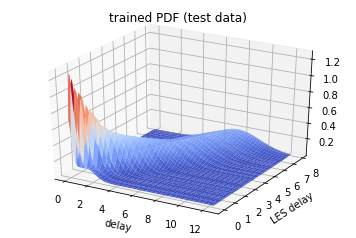

. 
. 
. 
. 
. 
. 
. 
. 
. 
. 


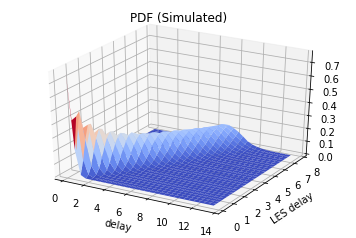

In [28]:
matlab_mode = 0
%matplotlib inline  
test_pred = model.predict(test_data)
# mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
mus = test_pred[:, :num_mixes * output_dim]
sigs = test_pred[:, num_mixes * output_dim:2 * num_mixes * output_dim]
pis = softmax(test_pred[:, -num_mixes:])

# rho, N = 0.9, 10
train_len = np.shape(train_data)[0]
test_len = np.shape(test_data)[0]
index_sorted_data = np.argsort(testdata[:, 0])
sorted_data = testdata[:, 0][index_sorted_data]
mus = mus[index_sorted_data]
sigs = sigs[index_sorted_data]
pis = pis[index_sorted_data]
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
# nbins = test_data.shape[0]
nbins = 100
# x, y = np.mgrid[testdata[:, 0].min():testdata[:, 0].max():nbins * 1j, test_labels.min():test_labels.max():nbins * 1j]
y = np.tile(sorted_data.reshape(1, -1), (nbins, 1))
xi = np.linspace(0.5*test_labels.min(), 1.2*test_labels.max(), nbins)
x = np.tile(xi.reshape(-1, 1), (1, y.shape[1]))

# yi = np.mgrid[test_labels.min():test_labels.max():nbins * 1j]

z = np.zeros(x.shape)
z_th = np.zeros(x.shape)
for j in range(x.shape[1]):
    for i in range(num_mixes):
        z[:, j] = z[:, j] + pis[j, i] * mlab.normpdf(xi, mus[j, i], sigs[j, i])

    z_th[:, j] = mlab.normpdf(xi, conditional_mean(rho, sorted_data[j], N), conditional_std(rho, sorted_data[j], N))

if matlab_mode:
    xm = matlab.double(x.tolist())
    ym = matlab.double(y.tolist())
    zm = matlab.double(z.tolist())
    h = eng.figure()
    eng.mesh(xm, ym, zm)
    eng.xlabel('delay')
    eng.ylabel('LES delay')
    eng.title('trained PDF (test data)')
    fig_path = directory + '/figs/PDF(trained) %s_%s_%d (rho %3.2f_numMixes %d).fig' % (ArrivalType, ServiceType, N, rho, num_mixes)
    eng.savefig(fig_path, nargout=0)

else:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, z, cmap=cm.coolwarm)
    plt.xlabel('delay')
    plt.ylabel('LES delay')
    plt.title('trained PDF (test data)')
    plt.show()
    fig_path = directory+'/figs/PDF(trained) %s_%s_%d (rho %3.2f_numMixes %d).pdf' % (ArrivalType, ServiceType, N, rho, num_mixes)
    fig.savefig(fig_path, bbox_inches='tight')
    

if ArrivalType == 'M' and ServiceType == 'M':
    if matlab_mode:
        xm = matlab.double(x.tolist())
        ym = matlab.double(y.tolist())
        z_thm = matlab.double(z_th.tolist())
        h = eng.figure()
        eng.mesh(xm, ym, z_thm)
        eng.xlabel('delay')
        eng.ylabel('LES delay')
        eng.title('PDF (Gaussian approx.)')
        fig_path = directory + '/figs/PDF(Gaussian approx) %s_%s_%d (rho %3.2f_numMixes %d).fig' % (ArrivalType, ServiceType, N, rho, num_mixes)
        eng.savefig(fig_path, nargout=0)

    else:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_surface(x, y, z_th, cmap=cm.coolwarm)
        plt.xlabel('delay')
        plt.ylabel('LES delay')
        plt.title('PDF (Gaussian approx.)')
        plt.show()
        fig_path = directory+'/figs/PDF(Gaussian approx) %s_%s_%d (rho %3.2f_numMixes %d).pdf' %(ArrivalType, ServiceType, N, rho, num_mixes)
        fig.savefig(fig_path, bbox_inches='tight')

w = np.linspace(min(testdata[:, 0]), max(testdata[:, 0]), 1000)
dataset_gen_dist = data_gen_dist_based(w, N, mean_Ta, mean_Ts)
nbins = 30
z_sim, x_sim, y_sim = np.histogram2d(dataset_gen_dist[:, 1].flatten(), dataset_gen_dist[:, 0].flatten(), nbins, normed='True')
# \\\\\\\\\\\\\\Normalization for getting the conditional distribution\\\\\\\\\
eps = 10**-15
z_sim = z_sim/(np.sum(z_sim, axis=0, keepdims=True)+eps)
#\\\\\\calculating centers of the bins\\\\\\
x_sim = (x_sim[:-1]+x_sim[1:])/2.0
y_sim = (y_sim[:-1]+y_sim[1:])/2.0
# \\\\\\\\\\\\\Making it ready for the meshplot\\\\\\\\\\\\\
x_sim = np.tile(x_sim.reshape(-1, 1), (1, nbins))
y_sim = np.tile(y_sim.reshape(1, -1), (nbins, 1))
# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
if matlab_mode:
    x_sim_m = matlab.double(x_sim.tolist())
    y_sim_m = matlab.double(y_sim.tolist())
    z_sim_m = matlab.double(z_sim.tolist())
    h = eng.figure()
    eng.mesh(x_sim_m, y_sim_m, z_sim_m)
    eng.xlabel('delay')
    eng.ylabel('LES delay')
    eng.title('PDF (Simulated)')
    fig_path = directory + '/figs/PDF(Simulated) %s_%s_%d (rho %3.2f_numMixes %d).fig' % (ArrivalType, ServiceType, N, rho, num_mixes)
    eng.savefig(fig_path, nargout=0)
else:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x_sim, y_sim, z_sim, cmap=cm.coolwarm)
    plt.xlabel('delay')
    plt.ylabel('LES delay')
    plt.title('PDF (Simulated)')
    plt.show()
    fig_path = directory+'/figs/PDF(Simulated) %s_%s_%d (rho %3.2f_numMixes %d).pdf' % (ArrivalType, ServiceType, N, rho, num_mixes)
    fig.savefig(fig_path, bbox_inches='tight')
    # scipy.io.savemat('Delay_PDF.mat', dict(x=x, y=y, z=z, z_th=z_th, x_sim=x_sim, y_sim=y_sim, z_sim=z_sim, N=N, rho=rho))


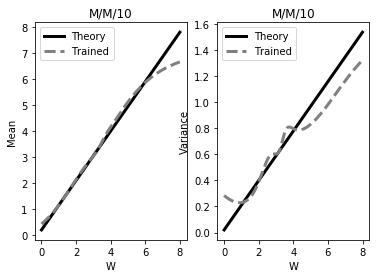

/Users/majidraeis/venv/lib/python2.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/Users/majidraeis/venv/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/Users/majidraeis/venv/lib/python2.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


Theoretical estimation of the training error:   inf, Calculated training error after learning:  1.18
Theoretical estimation of the test error:  2.39, Calculated test error after learning:  0.84


/Users/majidraeis/venv/lib/python2.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/Users/majidraeis/venv/lib/python2.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


In [21]:

# \\\\\\\\\\\\\\\\\\\\\\\\\\\\PLOTTING MEAN AND VARIANCE //////////////////////////////
predicted_train = model.predict(train_data)
mus = predicted_train[:, :num_mixes * output_dim]
sigs = predicted_train[:, num_mixes * output_dim:2 * num_mixes * output_dim]
pis = softmax(predicted_train[:, -num_mixes:])
mean_sim = np.zeros(train_len)
var_sim = np.zeros(train_len)
mean_th = np.zeros(train_len)
var_th = np.zeros(train_len)
for q in range(train_len):
    w = dataSet[q, 0]
    y = train_labels[q]
    # \\\\\Theory\\\\\\\
    if ArrivalType == "M":  # Exact mean and variance
        mean_th[q] = rho * w + 2.0 / N
        var_th[q] = (2 * rho * w) / N + 2.0 / (N ** 2)

    elif ArrivalType == "H2":  # Asymptotic mean and variance
        mean_th[q] = rho*w + (c_a**2+3)/(2*N)
        var_th[q] = rho*w*(c_a**2+1)/N  # + ((5*(c**2+1)**2)/4 - (2*)/3 +1)/(N**2)

    # \\\\\trained\\\\\
    mean_sim[q] = np.inner(pis[q], mus[q])
    var_sim[q] = np.inner(pis[q], mus[q]**2+sigs[q]**2) - mean_sim[q]**2


index_sorted_train_data = np.argsort(dataSet[:, 0])
fig = plt.figure()
plt.subplot(121)
plt.xlabel('W')
plt.ylabel('Mean')
plt.plot(dataSet[index_sorted_train_data, 0], mean_th[index_sorted_train_data], c='k', lw=3., label='Theory')
plt.plot(dataSet[index_sorted_train_data, 0], mean_sim[index_sorted_train_data], c='0.5', lw=3., ls='--', label='Trained')
plt.legend()
plt.title('%s/M/%d'%(ArrivalType, N))
plt.subplot(122)
plt.xlabel('W')
plt.ylabel('Variance')
plt.plot(dataSet[index_sorted_train_data, 0], var_th[index_sorted_train_data], c='k', lw=3., label='Theory')
plt.plot(dataSet[index_sorted_train_data, 0], var_sim[index_sorted_train_data], c='0.5', lw=3., ls='--', label='Trained')
plt.legend()
plt.title('%s/M/%d'%(ArrivalType, N))
plt.show()
fig_path = directory+'/figs/meanVar %s_%s_%d (rho %3.2f_numMixes %d).pdf' % (ArrivalType, ServiceType, N, rho, num_mixes)
fig.savefig(fig_path, bbox_inches='tight')
# \\\\\\\\\\\\\\\\\\\\\\\\\TRAINING\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
if ArrivalType == 'M':
    # \\\\\\\\Calculating the theoretical loss for M/M/N   \\\\\\\\\\\\\\
    e_opt = 0
    for q in range(train_len):
        w = dataSet[q, 0]
        y = dataSet[q, 1]
        e_opt = e_opt - np.log(mlab.normpdf(y, rho*w + 2.0/N, ((2.0*rho*w)/N + 2.0/(N**2))**0.5))
    e_opt = e_opt/train_len
    # \\\\\\\\Calculating the loss after training   \\\\\\\\\\\\\\
    e = 0
    predicted_train = model.predict(train_data)
    mus = predicted_train[:, :num_mixes * output_dim]
    sigs = predicted_train[:, num_mixes * output_dim:2 * num_mixes * output_dim]
    pis = softmax(predicted_train[:, -num_mixes:])
    for q in range(train_len):
        y = dataSet[q, 1]
        h = 0
        for i in range(num_mixes):
            h = h + pis[q, i] * mlab.normpdf(y, mus[q, i], sigs[q, i])
        e = e - np.log(h)
    e = e/train_len

    print("Theoretical estimation of the training error: %5.2f, Calculated training error after learning: %5.2f" %(e_opt, e))

    # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\TEST\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

    # \\\\\\\\Calculating the theoretical loss for M/M/N   \\\\\\\\\\\\\\
    e_opt = 0
    for q in range(test_len):
        w = testdata[q, 0]
        y = testdata[q, 1]
        e_opt = e_opt - np.log(mlab.normpdf(y, rho*w + 2.0/N, ((2*rho*w)/N + 2.0/(N**2))**0.5))
    e_opt = e_opt/test_len
    # \\\\\\\\Calculating the loss after training   \\\\\\\\\\\\\\
    e = 0
    test_pred = model.predict(test_data)
    mus = test_pred[:, :num_mixes * output_dim]
    sigs = test_pred[:, num_mixes * output_dim:2 * num_mixes * output_dim]
    pis = softmax(test_pred[:, -num_mixes:])
    for q in range(test_len):
        y = testdata[q, 1]
        h = 0
        for i in range(num_mixes):
            h = h + pis[q, i] * mlab.normpdf(y, mus[q, i], sigs[q, i])
        e = e - np.log(h)
    e = e/test_len

    print("Theoretical estimation of the test error: %5.2f, Calculated test error after learning: %5.2f" %(e_opt, e))

